In [1]:
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import numpy as np
import imageio
import cv2
import os
import datetime

In [2]:
!pip install imageio

In [3]:
!pip install -q git+https://github.com/tensorflow/docs

In [4]:
from tensorflow import keras
from keras.utils.vis_utils import plot_model
import imageio
from tensorflow_docs.vis import embed

In [5]:
DATASET_FOLDER = "../input/real-time-anomaly-detection-in-cctv-surveillance/data"

In [6]:
dataset = os.listdir(DATASET_FOLDER)
label_types = os.listdir(DATASET_FOLDER)
print("Class Labels for Videos : ")
label_types.remove('test.csv')
label_types.remove('train.csv')
print(label_types)

Class Labels for Videos : 
['roadaccidents', 'assault', 'vandalism', 'arrest', 'shooting', 'arson', 'explosion', 'normal', 'shoplifting', 'robbery', 'stealing', 'burglary', 'abuse', 'fighting']


## Dataset Analysis

In [7]:
video_counts = []
total = 0
for i in range(len(label_types)):
    videos = len(os.listdir(os.path.join(DATASET_FOLDER, label_types[i])))
    video_counts.append(videos)
    total += videos

print(f"Total videos : {total}")
print(label_types)
print(video_counts)

Total videos : 1900
['roadaccidents', 'assault', 'vandalism', 'arrest', 'shooting', 'arson', 'explosion', 'normal', 'shoplifting', 'robbery', 'stealing', 'burglary', 'abuse', 'fighting']
[150, 50, 50, 50, 50, 50, 50, 950, 50, 150, 100, 100, 50, 50]


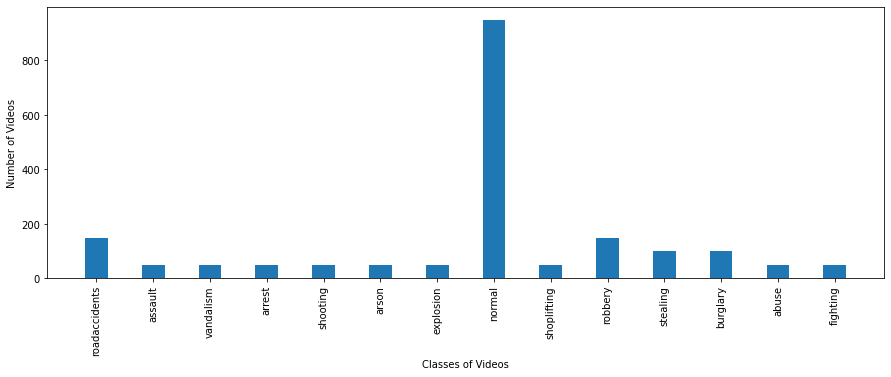

In [8]:
plt.figure(figsize=(15,5))
plt.bar(label_types, video_counts, width=0.4, align="center" )
plt.xticks(rotation=90)

plt.xlabel("Classes of Videos")
plt.ylabel("Number of Videos")
plt.show()

Text(0.5, 1.0, 'Share of Different Types Of Training Videos')

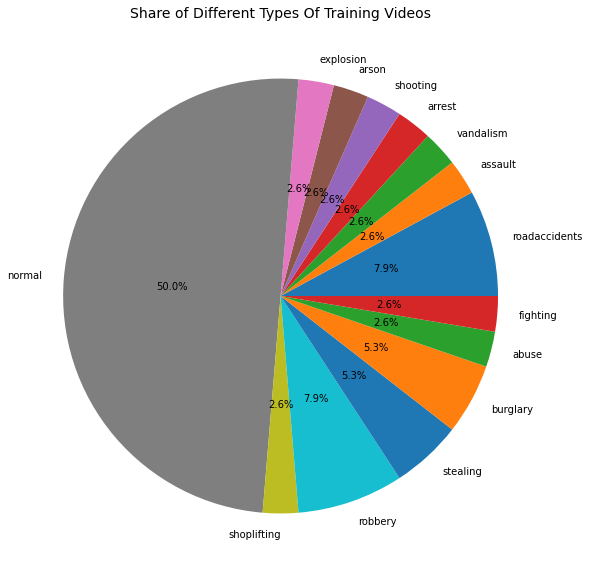

In [9]:
plt.figure(figsize=(15,10))
plt.pie(x=np.array(video_counts), autopct="%.1f%%", labels=label_types, pctdistance=0.5)
plt.title("Share of Different Types Of Training Videos", fontsize=14)

## Train and Test Split:

In [10]:
LABEL_COL = "label"
VIDEO_INFO_COL = "video_name"

In [11]:
data = []

for i in range(len(label_types)):
    for video in os.listdir(os.path.join(DATASET_FOLDER, label_types[i])): 
        data.append( (label_types[i] , f"../input/real-time-anomaly-detection-in-cctv-surveillance/data/{label_types[i]}/{video}") )

df = pd.DataFrame(data=data, columns=[ LABEL_COL, VIDEO_INFO_COL])

print(df)

              label                                         video_name
0     roadaccidents  ../input/real-time-anomaly-detection-in-cctv-s...
1     roadaccidents  ../input/real-time-anomaly-detection-in-cctv-s...
2     roadaccidents  ../input/real-time-anomaly-detection-in-cctv-s...
3     roadaccidents  ../input/real-time-anomaly-detection-in-cctv-s...
4     roadaccidents  ../input/real-time-anomaly-detection-in-cctv-s...
...             ...                                                ...
1895       fighting  ../input/real-time-anomaly-detection-in-cctv-s...
1896       fighting  ../input/real-time-anomaly-detection-in-cctv-s...
1897       fighting  ../input/real-time-anomaly-detection-in-cctv-s...
1898       fighting  ../input/real-time-anomaly-detection-in-cctv-s...
1899       fighting  ../input/real-time-anomaly-detection-in-cctv-s...

[1900 rows x 2 columns]


In [12]:
x = df[VIDEO_INFO_COL]
y = df[LABEL_COL]

In [13]:
from sklearn.model_selection import train_test_split

In [14]:
train, test = train_test_split(df, test_size = 0.2, stratify=y)

In [15]:
train.value_counts(LABEL_COL)

label
normal           760
roadaccidents    120
robbery          120
burglary          80
stealing          80
abuse             40
arrest            40
arson             40
assault           40
explosion         40
fighting          40
shooting          40
shoplifting       40
vandalism         40
dtype: int64

In [16]:
test.value_counts(LABEL_COL)

label
normal           190
roadaccidents     30
robbery           30
burglary          20
stealing          20
abuse             10
arrest            10
arson             10
assault           10
explosion         10
fighting          10
shooting          10
shoplifting       10
vandalism         10
dtype: int64

Text(0.5, 1.0, 'Share of Training and Testing Videos')

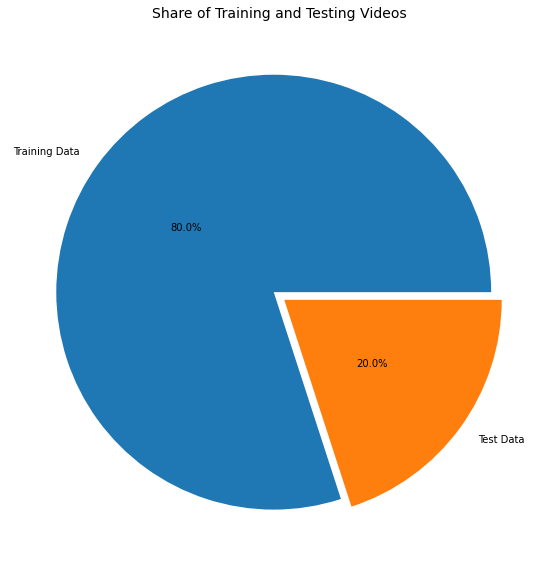

In [17]:
plt.figure(figsize=(15, 10))
plt.pie(x=np.array([len(train), len(test)]), autopct="%.1f%%", explode=[0.03, 0.03], labels=["Training Data", "Test Data"], pctdistance=0.5)
plt.title("Share of Training and Testing Videos", fontsize=14)

In [18]:
train.to_csv("../working/train.csv")
test.to_csv("../working/test.csv")

### Data Collection :

In [19]:
train_df = pd.read_csv("../working/train.csv")
test_df = pd.read_csv("../working/test.csv")

In [20]:
print(f"Total videos for training : {len(train_df)}")
print(f"Total videos for testing  : {len(test_df)}")

print("Training Dataframe : ")
print(train_df.head(10))

print("Testing Dataset    : ")
print(test_df.head(10))

Total videos for training : 1520
Total videos for testing  : 380
Training Dataframe : 
   Unnamed: 0          label  \
0        1220         normal   
1         131  roadaccidents   
2        1486        robbery   
3        1710       burglary   
4        1895       fighting   
5        1511        robbery   
6         952         normal   
7         796         normal   
8         667         normal   
9         371          arson   

                                          video_name  
0  ../input/real-time-anomaly-detection-in-cctv-s...  
1  ../input/real-time-anomaly-detection-in-cctv-s...  
2  ../input/real-time-anomaly-detection-in-cctv-s...  
3  ../input/real-time-anomaly-detection-in-cctv-s...  
4  ../input/real-time-anomaly-detection-in-cctv-s...  
5  ../input/real-time-anomaly-detection-in-cctv-s...  
6  ../input/real-time-anomaly-detection-in-cctv-s...  
7  ../input/real-time-anomaly-detection-in-cctv-s...  
8  ../input/real-time-anomaly-detection-in-cctv-s...  
9  ../inpu

### Feed the videos to a Network : 

In [21]:
IMG_SIZE = 224

def crop_center_square(frame):
    y, x = frame.shape[0:2]
    min_dim = min(y,x)
    # print(f"y : {y}      and      x : {x}")
    start_x = (x // 2) -  (min_dim // 2) 
    start_y = (y // 2) -  (min_dim // 2)
    return frame[ start_y : start_y+min_dim, start_x : start_x + min_dim]

In [22]:
def load_video(path, max_frames = 101, resize = (IMG_SIZE, IMG_SIZE)):

    cap = cv2.VideoCapture(path)
    framestot = cap.get(cv2.CAP_PROP_FRAME_COUNT)
    fps = cap.get(cv2.CAP_PROP_FPS)

    # calculate duration of the video
    seconds = round(framestot / fps)
    video_time = datetime.timedelta(seconds=seconds)
    
    print(f"Total frames {framestot}")
    print(f"Frames per sec {fps}")
    print(f"duration in seconds: {seconds}")
    print(f"video time: {video_time}")
    # allPaths = path.split('/')
    # videoNameAndExt = allPaths[2].split('.')
    # videoName = videoNameAndExt[0] 
    frames = []
    # i = 0
    try:
        while True:
            ret, frame = cap.read()
            if not ret:
                break
            # if (not os.path.exists('frames/'+videoName)):
            #     os.mkdir('frames/'+videoName)
            frame = crop_center_square(frame)
            frame = cv2.resize(frame, resize)
            frame = frame[:, :, [2,1,0]]
            # cv2.imwrite('frames/'+ videoName +'/Frame'+ str(i) +'.jpg', frame)
            frames.append(frame)
            # i+=1
            if(len(frames) == max_frames):
                break
    finally:
        cap.release()
    return np.array(frames)

In [23]:
def build_feature_extractor():
    feature_extractor = keras.applications.InceptionV3(
        weights="imagenet",
        include_top=False,
        pooling="avg",
        input_shape=(IMG_SIZE, IMG_SIZE, 3),
    )
    preprocess_input = keras.applications.inception_v3.preprocess_input

    inputs = keras.Input((IMG_SIZE, IMG_SIZE, 3))
    preprocessed = preprocess_input(inputs)

    outputs = feature_extractor(preprocessed)
    return keras.Model(inputs, outputs, name="feature_extractor")

In [24]:
feature_extractor = build_feature_extractor()

2022-12-27 11:47:21.497310: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


87924736/87910968 [==============================] - 4s 0us/step


In [25]:
print(feature_extractor.summary())

Model: "feature_extractor"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
tf.math.truediv (TFOpLambda) (None, 224, 224, 3)       0         
_________________________________________________________________
tf.math.subtract (TFOpLambda (None, 224, 224, 3)       0         
_________________________________________________________________
inception_v3 (Functional)    (None, 2048)              21802784  
Total params: 21,802,784
Trainable params: 21,768,352
Non-trainable params: 34,432
_________________________________________________________________
None


### Label Encoding
StringLookup layer encode the class labels as integers.

In [26]:
label_processor = keras.layers.StringLookup(num_oov_indices=0, vocabulary=np.unique(train_df["label"]))
print(label_processor.get_vocabulary())

labels = train_df["label"].values
labels = label_processor(labels[..., None]).numpy()
labels

['abuse', 'arrest', 'arson', 'assault', 'burglary', 'explosion', 'fighting', 'normal', 'roadaccidents', 'robbery', 'shooting', 'shoplifting', 'stealing', 'vandalism']


array([[7],
       [8],
       [9],
       ...,
       [4],
       [7],
       [7]])

<b>Finally, we can put all the pieces together to create our data processing utility.</b>

In [27]:
#Define hyperparameters

IMG_SIZE = 224
BATCH_SIZE = 64
EPOCHS = 100

MAX_SEQ_LENGTH = 100
NUM_FEATURES = 2048

In [28]:
def prepare_all_videos(df):
    num_samples = len(df)
    video_paths = df["video_name"].values.tolist()    
    
    ##take all classlabels from train_df column named 'label' and store in labels
    labels = df["label"].values

    #convert classlabels to label encoding
    labels = label_processor(labels[..., None]).numpy()

    # `frame_masks` and `frame_features` are what we will feed to our sequence model.
    # `frame_masks` will contain a bunch of booleans denoting if a timestep is
    # masked with padding or not.
    frame_masks = np.zeros(shape=(num_samples, MAX_SEQ_LENGTH), dtype="bool") 
    frame_features = np.zeros(shape=(num_samples, MAX_SEQ_LENGTH, NUM_FEATURES), dtype="float32") 

    # For each video.
    for idx, path in enumerate(video_paths):
        # Gather all its frames and add a batch dimension.
        print(f"\nProcessing video {idx+1} out of {num_samples}")
        
        frames = load_video(path)
        frames = frames[None, ...]
        # Initialize placeholders to store the masks and features of the current video.
        temp_frame_mask = np.zeros(shape=(1, MAX_SEQ_LENGTH,), dtype="bool")
        temp_frame_features = np.zeros(
            shape=(1, MAX_SEQ_LENGTH, NUM_FEATURES), dtype="float32"
        )

        # Extract features from the frames of the current video.
        for i, batch in enumerate(frames):
            video_length = batch.shape[0]
            print(f"Video Length received : {video_length}")
            length = min(MAX_SEQ_LENGTH, video_length)
            for j in range(length):
                print(j+1, end=' ')
                temp_frame_features[i, j, :] = feature_extractor.predict(
                    batch[None, j, :]
                )
            temp_frame_mask[i, :length] = 1  # 1 = not masked, 0 = masked

        frame_features[idx,] = temp_frame_features.squeeze()
        frame_masks[idx,] = temp_frame_mask.squeeze()

    return (frame_features, frame_masks), labels

In [ ]:
train_data, train_labels = prepare_all_videos(train_df)

In [30]:
train_data

(array([[[0.15155677, 0.77365595, 0.63837737, ..., 1.4548521 ,
          0.6024969 , 0.04551781],
         [0.1546604 , 0.7695594 , 0.6507201 , ..., 1.4590329 ,
          0.59539217, 0.04617955],
         [0.15054378, 0.7735941 , 0.64783394, ..., 1.4505196 ,
          0.58674693, 0.04622568],
         ...,
         [0.28796646, 0.75336856, 0.36138374, ..., 1.5704099 ,
          0.19277157, 0.10187418],
         [0.2880265 , 0.75307184, 0.36078033, ..., 1.5701327 ,
          0.19225733, 0.10166489],
         [0.17798643, 0.77042353, 0.4526857 , ..., 1.4000556 ,
          0.251441  , 0.08000295]],
 
        [[0.09472253, 0.109128  , 0.06323892, ..., 0.6492081 ,
          0.05647587, 0.01617351],
         [0.07976105, 0.12694275, 0.06911809, ..., 0.64940214,
          0.02276826, 0.        ],
         [0.06402515, 0.10215759, 0.07498021, ..., 0.6997646 ,
          0.02462787, 0.        ],
         ...,
         [0.23130174, 0.36172822, 1.6437603 , ..., 0.48405334,
          0.02786471, 0.

In [ ]:
test_data, test_labels = prepare_all_videos(test_df)

In [32]:
test_data

(array([[[0.36312297, 0.6296922 , 0.11539838, ..., 0.37227985,
          0.7880756 , 0.11903629],
         [0.3624704 , 0.69132525, 0.14260954, ..., 0.44541687,
          0.71234506, 0.09117069],
         [0.3822665 , 0.71424645, 0.1732064 , ..., 0.4181979 ,
          0.7396829 , 0.10882765],
         ...,
         [0.47380874, 0.7464324 , 0.2699671 , ..., 0.3990592 ,
          1.2904593 , 0.33507973],
         [0.3240049 , 0.70727104, 0.31549826, ..., 0.30106017,
          1.4483937 , 0.34928843],
         [0.39881432, 0.6868823 , 0.25067052, ..., 0.12971732,
          1.3263172 , 0.33872136]],
 
        [[0.21885271, 0.84296936, 0.11806604, ..., 0.23444065,
          0.5327984 , 0.19759771],
         [0.2501579 , 0.7849274 , 0.03679412, ..., 0.1204768 ,
          0.6933376 , 0.21612513],
         [0.1768161 , 0.8386204 , 0.0299454 , ..., 0.08452556,
          0.6798314 , 0.2767839 ],
         ...,
         [0.17682509, 1.0434779 , 0.33439088, ..., 0.94150865,
          0.7002722 , 0.

## The sequence model
Now, we can feed this data to a sequence model consisting of recurrent layers like GRU.

In [33]:
# Utility for our sequence model.
def get_sequence_model():
    class_vocab = label_processor.get_vocabulary()

    frame_features_input = keras.Input((MAX_SEQ_LENGTH, NUM_FEATURES))
    mask_input = keras.Input((MAX_SEQ_LENGTH,), dtype="bool")

    # Refer to the following tutorial to understand the significance of using `mask`:
    # https://keras.io/api/layers/recurrent_layers/gru/
    x = keras.layers.GRU(16, return_sequences=True)(frame_features_input, mask=mask_input)
    x = keras.layers.GRU(8)(x)
    x = keras.layers.Dropout(0.4)(x)
    x = keras.layers.Dense(8, activation="relu")(x)
    output = keras.layers.Dense(len(class_vocab), activation="softmax")(x)

    rnn_model = keras.Model([frame_features_input, mask_input], output)

    rnn_model.compile(
        loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"]
    )
    return rnn_model


In [34]:
EPOCHS = 100
# Utility for running experiments.
def run_experiment():
    filepath = "./tmp/video_classifier"
    checkpoint = keras.callbacks.ModelCheckpoint(
        filepath, save_weights_only=True, save_best_only=True, verbose=1
    )

    seq_model = get_sequence_model()
    history = seq_model.fit(
        [train_data[0], train_data[1]],
        train_labels,
        validation_split=0.3,
        epochs=EPOCHS,
        callbacks=[checkpoint],
    )

    seq_model.load_weights(filepath)
    _, accuracy = seq_model.evaluate([test_data[0], test_data[1]], test_labels)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")

    return history, seq_model

In [35]:
_, sequence_model = run_experiment()

Epoch 1/100
34/34 [==============================] - 19s 336ms/step - loss: 2.3856 - accuracy: 0.3647 - val_loss: 2.3206 - val_accuracy: 0.4518

Epoch 00001: val_loss improved from inf to 2.32057, saving model to ./tmp/video_classifier
Epoch 2/100
34/34 [==============================] - 7s 208ms/step - loss: 2.1966 - accuracy: 0.5169 - val_loss: 2.2100 - val_accuracy: 0.4518

Epoch 00002: val_loss improved from 2.32057 to 2.21001, saving model to ./tmp/video_classifier
Epoch 3/100
34/34 [==============================] - 7s 211ms/step - loss: 2.0710 - accuracy: 0.5207 - val_loss: 2.1373 - val_accuracy: 0.4518

Epoch 00003: val_loss improved from 2.21001 to 2.13726, saving model to ./tmp/video_classifier
Epoch 4/100
34/34 [==============================] - 7s 210ms/step - loss: 2.0148 - accuracy: 0.5188 - val_loss: 2.1054 - val_accuracy: 0.4518

Epoch 00004: val_loss improved from 2.13726 to 2.10545, saving model to ./tmp/video_classifier
Epoch 5/100
34/34 [============================

In [36]:
_.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

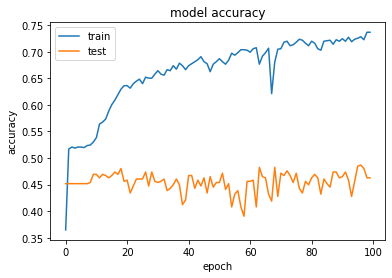

In [37]:
plt.plot(_.history['accuracy'])
plt.plot(_.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

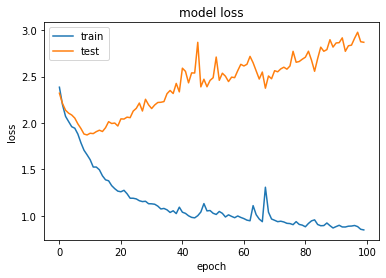

In [38]:
# summarize history for loss
plt.plot(_.history['loss'])
plt.plot(_.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Prediction

In [39]:
def prepare_single_video(frames):
    frames = frames[None, ...]
    frame_mask = np.zeros(shape=(1, MAX_SEQ_LENGTH,), dtype="bool")
    frame_features = np.zeros(shape=(1, MAX_SEQ_LENGTH, NUM_FEATURES), dtype="float32")

    for i, batch in enumerate(frames):
        video_length = batch.shape[0]
        length = min(MAX_SEQ_LENGTH, video_length)
        for j in range(length):
            frame_features[i, j, :] = feature_extractor.predict(batch[None, j, :])
        frame_mask[i, :length] = 1  # 1 = not masked, 0 = masked

    return frame_features, frame_mask

In [40]:
def sequence_prediction(path):
    class_vocab = label_processor.get_vocabulary()

    frames = load_video(os.path.join(path))
    frame_features, frame_mask = prepare_single_video(frames)
    probabilities = sequence_model.predict([frame_features, frame_mask])[0]

    for i in np.argsort(probabilities)[::-1]:
        print(f"  {class_vocab[i]}: {probabilities[i] * 100:5.2f}%")
    return frames

In [41]:
def to_gif(images):
    converted_images = images.astype(np.uint8)
    imageio.mimsave("animation.gif", converted_images, fps=10)
    return embed.embed_file("animation.gif")

Test video path: ../input/real-time-anomaly-detection-in-cctv-surveillance/data/roadaccidents/RoadAccidents040_x264.mp4
Total frames 1946.0
Frames per sec 30.0
duration in seconds: 65
video time: 0:01:05
  normal: 77.23%
  robbery:  4.75%
  roadaccidents:  4.59%
  burglary:  2.40%
  arrest:  2.18%
  abuse:  1.93%
  stealing:  1.58%
  fighting:  0.97%
  explosion:  0.81%
  assault:  0.77%
  arson:  0.74%
  shooting:  0.71%
  shoplifting:  0.68%
  vandalism:  0.65%



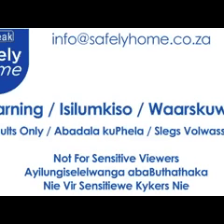

In [42]:
test_video = np.random.choice(test_df["video_name"].values.tolist())
print(f"Test video path: {test_video}")
test_frames = sequence_prediction(test_video)
to_gif(test_frames[:MAX_SEQ_LENGTH])